In [3]:
"""
hnsw_full_implementation.py

Production-ready HNSW (Hierarchical Navigable Small World) implementation in Python.

Features:
- Multi-layer HNSW graph with probabilistic level assignment
- Thread-safe incremental add_point (real-time inserts) and search
- ef_construction / ef_search parameters, M (max neighbors) and mL level multiplier
- Diversity-aware neighbor selection heuristic (HNSW paper / visual guide)
- Persistence: save() / load() (numpy + JSON)
- Deletion (lazy tombstone) + rebuild to compact the graph
- Support for Euclidean (L2) and Cosine distance metrics
- CLI for build/query/serve and simple FastAPI endpoint (optional)

Reference: "A Visual Guide to HNSW" (Christopher Fu, May 2024)
"""

from __future__ import annotations

import math
import random
import threading
import heapq
import json
import os
import argparse
from typing import List, Tuple, Dict, Optional, Callable

import numpy as np

try:
    from fastapi import FastAPI, HTTPException
    import uvicorn
    _HAS_FASTAPI = True
except Exception:
    _HAS_FASTAPI = False


# ---------------------------
# Distance metrics
# ---------------------------

def l2_distance(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.linalg.norm(a - b))


def cosine_distance(a: np.ndarray, b: np.ndarray) -> float:
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 1.0
    cos = float(np.dot(a, b) / (na * nb))
    return 1.0 - cos


_METRICS: Dict[str, Callable[[np.ndarray, np.ndarray], float]] = {
    "l2": l2_distance,
    "cosine": cosine_distance,
}


# ---------------------------
# HNSW Class
# ---------------------------

class HNSW:
    """Hierarchical Navigable Small World index.

    Attributes:
        dim: vector dimensionality
        M: max neighbors per node (levels > 0)
        ef_construction: ef used during insertion
        ef_search: default ef used during queries
        mL: level multiplier for random level generation
        metric_name: 'l2' or 'cosine'
    """

    def __init__(self,
                 dim: int,
                 M: int = 16,
                 ef_construction: int = 200,
                 ef_search: int = 50,
                 mL: Optional[float] = None,
                 metric: str = "l2",
                 max_m0: Optional[int] = None,
                 seed: Optional[int] = 42):
        if metric not in _METRICS:
            raise ValueError(f"Unsupported metric: {metric}")

        self.dim = int(dim)
        self.M = int(M)
        self.ef_construction = int(ef_construction)
        self.ef_search = int(ef_search)
        self.mL = float(mL) if mL is not None else 1.0 / math.log(max(2, M))
        self.metric_name = metric
        self._dist_fn = _METRICS[metric]

        # degree cap for layer 0 can be larger; default to 2*M if not provided
        self.max_m0 = int(max_m0) if max_m0 is not None else (self.M * 2)

        # core storage
        self.vectors: List[np.ndarray] = []
        self.levels: List[int] = []
        self.graph: List[Dict[int, List[int]]] = []
        self.tombstones: List[bool] = []

        # concurrency
        self._lock = threading.RLock()
        self.entry_point: Optional[int] = None
        self.max_layer: int = -1

        # RNG
        self._rand = random.Random(seed)

    # ----------------
    # Low-level helpers
    # ----------------
    def _random_level(self) -> int:
        # Random level generation: floor(-ln(U) * mL)
        u = self._rand.random()
        if u <= 0.0:
            u = 1e-16
        lvl = int(-math.log(u) * self.mL)
        return lvl

    def _dist(self, a_idx: int, vec: np.ndarray) -> float:
        return self._dist_fn(self.vectors[a_idx], vec)

    # ----------------
    # Neighbor selection heuristic
    # ----------------
    def _select_neighbors(self, candidates: List[Tuple[float, int]], M: int) -> List[int]:
        """Select up to M neighbors from candidates (sorted by dist asc) using HNSW heuristic.

        The heuristic prefers diverse neighbors: a candidate is skipped if an already selected
        neighbor is closer to the candidate than the candidate's distance to the query (redundancy check).
        """
        selected: List[int] = []
        for dist, nid in candidates:
            ok = True
            for sid in selected:
                d_between = self._dist_fn(self.vectors[sid], self.vectors[nid])
                if d_between < dist:
                    ok = False
                    break
            if ok:
                selected.append(nid)
                if len(selected) >= M:
                    break
        return selected

    # ----------------
    # ef-search on a layer
    # ----------------
    def _search_layer(self, query_vec: np.ndarray, entry_point: int, ef: int, layer: int) -> List[int]:
        """Return up to ef best candidates on a given layer starting from entry_point."""
        visited = set()
        # top_candidates: max-heap by negative distance (keeps best ef found so far)
        top_heap: List[Tuple[float, int]] = []
        # candidates: min-heap by distance for exploration
        cand_heap: List[Tuple[float, int]] = []

        entry_dist = self._dist(entry_point, query_vec)
        heapq.heappush(top_heap, (-entry_dist, entry_point))
        heapq.heappush(cand_heap, (entry_dist, entry_point))
        visited.add(entry_point)

        while cand_heap:
            cur_dist, cur = cand_heap[0]
            # worst distance among top candidates (smallest priority in max-heap)
            worst_top = -top_heap[0][0]
            if len(top_heap) >= ef and cur_dist > worst_top:
                break
            heapq.heappop(cand_heap)
            neighs = self.graph[cur].get(layer, [])
            for n in neighs:
                if self.tombstones[n]:
                    continue
                if n in visited:
                    continue
                visited.add(n)
                d = self._dist(n, query_vec)
                if len(top_heap) < ef or d < -top_heap[0][0]:
                    heapq.heappush(cand_heap, (d, n))
                    heapq.heappush(top_heap, (-d, n))
                    if len(top_heap) > ef:
                        heapq.heappop(top_heap)

        # extract sorted ascending by distance
        res = sorted([(-d, nid) for (d, nid) in top_heap], key=lambda x: x[0])
        return [nid for (_d, nid) in res]

    # ----------------
    # Public API
    # ----------------
    def add_point(self, vector: np.ndarray) -> int:
        """Insert a vector into the HNSW index and return its id. Thread-safe."""
        if vector.shape[0] != self.dim:
            raise ValueError("Vector dimensionality mismatch")
        vec = vector.astype(np.float32)

        with self._lock:
            vid = len(self.vectors)
            self.vectors.append(vec)
            lvl = self._random_level()
            self.levels.append(lvl)
            self.tombstones.append(False)
            self.graph.append({})
            for l in range(lvl + 1):
                self.graph[vid].setdefault(l, [])

            # first element
            if self.entry_point is None:
                self.entry_point = vid
                self.max_layer = lvl
                return vid

            cur_ep = self.entry_point
            cur_max = self.max_layer

            # 1) greedy descent from top layer down to lvl+1 using ef=1 like greedy search
            for layer in range(cur_max, lvl, -1):
                improved = True
                while improved:
                    improved = False
                    neighs = self.graph[cur_ep].get(layer, [])
                    for n in neighs:
                        if self.tombstones[n]:
                            continue
                        if self._dist(n, vec) < self._dist(cur_ep, vec):
                            cur_ep = n
                            improved = True

            # 2) for layers <= lvl, run ef_construction (or ef=1) searches and connect
            for layer in range(min(lvl, cur_max), -1, -1):
                ef = self.ef_construction if layer <= lvl else 1
                ef = max(ef, 1)
                candidates = self._search_layer(vec, cur_ep, ef=ef, layer=layer)
                cand_dists = sorted([(self._dist(cid, vec), cid) for cid in candidates], key=lambda x: x[0])

                M_here = self.M if layer > 0 else self.max_m0
                selected = self._select_neighbors(cand_dists, M_here)

                # link bidirectionally and prune neighbor lists if needed
                for neigh in selected:
                    self.graph[vid].setdefault(layer, []).append(neigh)
                    neigh_adj = self.graph[neigh].setdefault(layer, [])
                    neigh_adj.append(vid)
                    if len(neigh_adj) > (self.M if layer > 0 else self.max_m0):
                        # prune to best by distance to neighbor
                        neigh_list = sorted([(self._dist(x, self.vectors[neigh]) if isinstance(self.vectors[neigh], np.ndarray) else self._dist(x, self.vectors[neigh]), x) for x in neigh_adj], key=lambda x: x[0])
                        keep = [x[1] for x in neigh_list[: (self.M if layer > 0 else self.max_m0)]]
                        self.graph[neigh][layer] = keep

                # set cur_ep to best candidate for next lower layer (closest)
                if len(cand_dists) > 0:
                    cur_ep = cand_dists[0][1]

            # update global entry point if this node has highest level
            if lvl > self.max_layer:
                self.max_layer = lvl
                self.entry_point = vid

            return vid

    def search(self, query_vec: np.ndarray, k: int = 10, ef: Optional[int] = None) -> List[Tuple[int, float]]:
        """Search k nearest neighbors. Returns list of (id, distance). Thread-safe."""
        if query_vec.shape[0] != self.dim:
            raise ValueError("Query dimensionality mismatch")
        with self._lock:
            if self.entry_point is None:
                return []
            ef = max(self.ef_search if ef is None else ef, k)

            cur = self.entry_point
            # greedy descent on higher layers
            for layer in range(self.max_layer, 0, -1):
                improved = True
                while improved:
                    improved = False
                    neighs = self.graph[cur].get(layer, [])
                    for n in neighs:
                        if self.tombstones[n]:
                            continue
                        if self._dist(n, query_vec) < self._dist(cur, query_vec):
                            cur = n
                            improved = True

            # base layer ef-search
            candidates = self._search_layer(query_vec, cur, ef=ef, layer=0)
            scored = [(nid, self._dist(nid, query_vec)) for nid in candidates]
            scored_sorted = sorted(scored, key=lambda x: x[1])[:k]
            return scored_sorted

    def delete(self, node_id: int) -> bool:
        """Lazy delete: mark node as tombstone. Returns True if deleted."""
        with self._lock:
            if node_id < 0 or node_id >= len(self.vectors):
                return False
            if self.tombstones[node_id]:
                return False
            self.tombstones[node_id] = True
            # Do not eagerly remove edges here — optional background cleanup can prune lists.
            return True

    # ----------------
    # Persistence
    # ----------------
    def save(self, path: str) -> None:
        """Save index to directory `path`. Creates directory if necessary."""
        os.makedirs(path, exist_ok=True)
        # stack vectors into 2D array
        if len(self.vectors) > 0:
            vecs = np.stack(self.vectors).astype(np.float32)
        else:
            vecs = np.zeros((0, self.dim), dtype=np.float32)
        np.save(os.path.join(path, "vectors.npy"), vecs)
        np.save(os.path.join(path, "levels.npy"), np.array(self.levels, dtype=np.int32))
        np.save(os.path.join(path, "tombstones.npy"), np.array(self.tombstones, dtype=np.bool_))

        # graph: serialize adjacency lists
        graph_serial = []
        for node_adj in self.graph:
            serial = {str(l): list(neighs) for l, neighs in node_adj.items()}
            graph_serial.append(serial)
        with open(os.path.join(path, "graph.json"), "w") as f:
            json.dump(graph_serial, f)

        meta = {
            "dim": self.dim,
            "M": self.M,
            "ef_construction": self.ef_construction,
            "ef_search": self.ef_search,
            "mL": self.mL,
            "metric": self.metric_name,
            "max_m0": self.max_m0,
            "entry_point": self.entry_point,
            "max_layer": self.max_layer,
        }
        with open(os.path.join(path, "meta.json"), "w") as f:
            json.dump(meta, f)

    @classmethod
    def load(cls, path: str) -> "HNSW":
        """Load an index from directory `path`."""
        with open(os.path.join(path, "meta.json"), "r") as f:
            meta = json.load(f)
        dim = int(meta["dim"])
        M = int(meta["M"])
        efc = int(meta.get("ef_construction", 200))
        efs = int(meta.get("ef_search", 50))
        mL = float(meta.get("mL", None)) if meta.get("mL", None) is not None else None
        metric = meta.get("metric", "l2")
        max_m0 = int(meta.get("max_m0", M * 2))

        idx = cls(dim=dim, M=M, ef_construction=efc, ef_search=efs, mL=mL, metric=metric, max_m0=max_m0)

        vecs = np.load(os.path.join(path, "vectors.npy"))
        levels = np.load(os.path.join(path, "levels.npy"))
        tomb = np.load(os.path.join(path, "tombstones.npy"))

        idx.vectors = [vecs[i].astype(np.float32) for i in range(vecs.shape[0])]
        idx.levels = [int(x) for x in levels.tolist()]
        idx.tombstones = [bool(x) for x in tomb.tolist()]

        with open(os.path.join(path, "graph.json"), "r") as f:
            graph_serial = json.load(f)
        idx.graph = []
        for node in graph_serial:
            d = {int(k): list(v) for k, v in node.items()}
            idx.graph.append(d)

        idx.entry_point = meta.get("entry_point", None)
        idx.max_layer = int(meta.get("max_layer", -1))
        return idx

    # ----------------
    # Rebuild after many deletions
    # ----------------
    def rebuild(self) -> "HNSW":
        """Return a new HNSW built from non-deleted vectors. Useful after many deletes."""
        with self._lock:
            alive_indices = [i for i, t in enumerate(self.tombstones) if not t]
            new_idx = HNSW(dim=self.dim, M=self.M, ef_construction=self.ef_construction,
                           ef_search=self.ef_search, mL=self.mL, metric=self.metric_name, max_m0=self.max_m0)
            for i in alive_indices:
                new_idx.add_point(self.vectors[i])
            return new_idx


# ---------------------------
# CLI and optional HTTP server
# ---------------------------

CLI_HELP = """
Simple CLI for building and querying the HNSW index.
Examples:
  python hnsw_full_implementation.py --build --n 1000 --dim 128 --out idx_dir
  python hnsw_full_implementation.py --load idx_dir --query-file queries.npy --k 5
  python hnsw_full_implementation.py --serve --load idx_dir --port 8000
"""


def _cli_build(args):
    idx = HNSW(dim=args.dim, M=args.M, ef_construction=args.efc, ef_search=args.efs, mL=args.mL, metric=args.metric)
    print(f"Building index with n={args.n}, dim={args.dim}")
    for i in range(args.n):
        vec = np.random.randn(args.dim).astype(np.float32)
        idx.add_point(vec)
        if (i + 1) % 1000 == 0:
            print(f"Inserted {i+1} / {args.n}")
    idx.save(args.out)
    print(f"Saved index to {args.out}")


def _cli_query(args):
    idx = HNSW.load(args.load)
    if args.query_file is None:
        q = np.random.randn(idx.dim).astype(np.float32)
        res = idx.search(q, k=args.k, ef=args.ef)
        print(res)
    else:
        qs = np.load(args.query_file)
        for i in range(min(len(qs), args.max_queries)):
            res = idx.search(qs[i].astype(np.float32), k=args.k, ef=args.ef)
            print(i, res)


def _cli_serve(args):
    if not _HAS_FASTAPI:
        raise RuntimeError("FastAPI/uvicorn not installed. Install to use --serve")
    idx = HNSW.load(args.load)
    app = FastAPI()

    @app.post('/search')
    def search_endpoint(body: dict):
        q = body.get('q')
        if q is None:
            raise HTTPException(status_code=400, detail='q field (array) required')
        qarr = np.array(q, dtype=np.float32)
        k = int(body.get('k', 10))
        ef = body.get('ef', None)
        res = idx.search(qarr, k=k, ef=ef)
        return {'result': res}

    uvicorn.run(app, host='0.0.0.0', port=args.port)




In [4]:
# Create an HNSW index
dim = 128  # Dimensionality of vectors
hnsw_index = HNSW(dim=dim, M=16, ef_construction=200, ef_search=50, metric="l2")

# Add some random vectors to the index
num_vectors = 100
print(f"Adding {num_vectors} random vectors...")
for i in range(num_vectors):
    vector = np.random.randn(dim).astype(np.float32)
    hnsw_index.add_point(vector)
print("Vectors added.")

# Perform a search query
query_vector = np.random.randn(dim).astype(np.float32)
k = 5  # Number of nearest neighbors to find
print(f"\nSearching for {k} nearest neighbors...")
results = hnsw_index.search(query_vector, k=k)

# Print the search results
print("Search results (node_id, distance):")
for node_id, distance in results:
    print(f"  {node_id}: {distance}")

Adding 100 random vectors...
Vectors added.

Searching for 5 nearest neighbors...
Search results (node_id, distance):
  10: 14.11213493347168
  55: 14.1301851272583
  35: 14.247376441955566
  65: 14.4413480758667
  89: 14.466874122619629


# Task
Apply the HNSW algorithm on a suitable dataset to retrieve similar items.

## Identify and load a suitable dataset

### Subtask:
Identify and load a suitable dataset


In [6]:
import tensorflow as tf
import numpy as np
import os

# Download the Fashion MNIST dataset
print("Downloading Fashion MNIST dataset...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print("Download complete.")

# Flatten the images to vectors and normalize
# We will use the training set as the base vectors and the test set as query vectors
base_vectors = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255.0
query_vectors = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255.0

print(f"Loaded base vectors shape: {base_vectors.shape}")
print(f"Loaded query vectors shape: {query_vectors.shape}")

4422102/4422102 [==============================] - 0s 0us/step
Download complete.
Loaded base vectors shape: (60000, 784)
Loaded query vectors shape: (10000, 784)


## Prepare data for hnsw

### Subtask:
Extract the numerical vectors from the dataset. Ensure they are in the correct format and dimensionality for the HNSW index.


**Reasoning**:
Verify the data types and dimensionalities of `base_vectors` and `query_vectors`.



In [7]:
# 1. Verify data types
print(f"Data type of base_vectors: {base_vectors.dtype}")
print(f"Data type of query_vectors: {query_vectors.dtype}")

# 2. Confirm dimensionality of base_vectors
# The dimensionality 'dim' is set based on the flattened Fashion MNIST images (28 * 28 = 784)
expected_dim = 784
print(f"Dimensionality of base_vectors: {base_vectors.shape[1]}")
print(f"Expected dimensionality (dim): {expected_dim}")
if base_vectors.shape[1] != expected_dim:
    print("Warning: Dimensionality of base_vectors does not match expected_dim.")

# 3. Ensure query_vectors have the same dimensionality
print(f"Dimensionality of query_vectors: {query_vectors.shape[1]}")
if query_vectors.shape[1] != base_vectors.shape[1]:
    print("Warning: Dimensionality of query_vectors does not match base_vectors.")

# Update the 'dim' variable used by the HNSW index if necessary, based on the actual data.
# Although 'dim' was previously set to 128 for demonstration, it should match the dataset.
dim = base_vectors.shape[1]
print(f"Updated dim variable to match base_vectors: {dim}")

Data type of base_vectors: float32
Data type of query_vectors: float32
Dimensionality of base_vectors: 784
Expected dimensionality (dim): 784
Dimensionality of query_vectors: 784
Updated dim variable to match base_vectors: 784


## Initialize and build hnsw index

### Subtask:
Create an instance of the `HNSW` class with appropriate parameters for the dataset's dimensionality and characteristics. Add the vectors from the dataset to the index.


**Reasoning**:
Instantiate the HNSW class and add the base vectors to the index with progress updates.



In [8]:
# 1. Instantiate the HNSW class
# Use the updated 'dim' variable which is 784
hnsw_index = HNSW(dim=dim, M=16, ef_construction=200, ef_search=50, metric="l2")
print(f"Initialized HNSW index with dim={dim}, M=16, ef_construction=200, ef_search=50, metric='l2'")

# 2. Add each vector from base_vectors to the index
num_base_vectors = base_vectors.shape[0]
print(f"\nAdding {num_base_vectors} base vectors to the index...")
for i in range(num_base_vectors):
    hnsw_index.add_point(base_vectors[i])
    if (i + 1) % 10000 == 0:
        print(f"Added {i + 1} / {num_base_vectors} vectors...")

# 3. Print the number of vectors added
print(f"\nFinished adding vectors. Total vectors added: {len(hnsw_index.vectors)}")

Initialized HNSW index with dim=784, M=16, ef_construction=200, ef_search=50, metric='l2'

Adding 60000 base vectors to the index...
Added 10000 / 60000 vectors...
Added 20000 / 60000 vectors...
Added 30000 / 60000 vectors...
Added 40000 / 60000 vectors...
Added 50000 / 60000 vectors...
Added 60000 / 60000 vectors...

Finished adding vectors. Total vectors added: 60000


## Perform retrieval/search

### Subtask:
Select a query vector (either from the dataset or a new vector) and use the `search` method of the HNSW index to find the nearest neighbors.


**Reasoning**:
Select a query vector from the query_vectors array, define the number of nearest neighbors, call the search method, and store the results.



In [9]:
# 1. Select a query vector
# We will use the first vector from the query_vectors array as the query
query_vector = query_vectors[0]
print(f"Selected query vector from query_vectors[0] with shape: {query_vector.shape}")

# 2. Define the number of nearest neighbors (k)
k = 10  # You can adjust this number as needed
print(f"Defined number of nearest neighbors (k): {k}")

# 3. Call the search method on the hnsw_index object
print(f"\nSearching for the {k} nearest neighbors...")
results = hnsw_index.search(query_vector, k=k)

# 4. Store the results (already done in the previous step)

# 5. Print a message indicating that the search is complete and show results
print("Search complete.")
print("Search results (node_id, distance):")
for node_id, distance in results:
    print(f"  Node ID: {node_id}, Distance: {distance:.4f}")

Selected query vector from query_vectors[0] with shape: (784,)
Defined number of nearest neighbors (k): 10

Searching for the 10 nearest neighbors...
Search complete.
Search results (node_id, distance):
  Node ID: 18094, Distance: 1.8914
  Node ID: 53939, Distance: 2.6745
  Node ID: 18352, Distance: 2.7784
  Node ID: 52468, Distance: 2.8613
  Node ID: 15081, Distance: 2.9884
  Node ID: 29768, Distance: 3.0169
  Node ID: 21342, Distance: 3.1030
  Node ID: 17346, Distance: 3.2311
  Node ID: 45266, Distance: 3.2524
  Node ID: 18339, Distance: 3.2607


## Analyze and display results

### Subtask:
Examine the retrieved neighbors and their distances. Display the results in a clear and informative way.


**Reasoning**:
Iterate through the results list and print the node ID and distance for each neighbor.



In [10]:
# 1. Iterate through the results list
print("Search results (node_id, distance):")
for node_id, distance in results:
    # 2. Print the node_id and its corresponding distance
    # 3. Format the distance to a reasonable number of decimal places
    print(f"  Node ID: {node_id}, Distance: {distance:.4f}")

# 4. Add a brief interpretation of the results
print("\nInterpretation:")
print(f"The search returned {len(results)} nearest neighbors for the query vector.")
print("Each result shows the ID of the vector in the index and its calculated distance from the query vector.")
print("Lower distance values indicate higher similarity between the stored vector and the query vector.")

Search results (node_id, distance):
  Node ID: 18094, Distance: 1.8914
  Node ID: 53939, Distance: 2.6745
  Node ID: 18352, Distance: 2.7784
  Node ID: 52468, Distance: 2.8613
  Node ID: 15081, Distance: 2.9884
  Node ID: 29768, Distance: 3.0169
  Node ID: 21342, Distance: 3.1030
  Node ID: 17346, Distance: 3.2311
  Node ID: 45266, Distance: 3.2524
  Node ID: 18339, Distance: 3.2607

Interpretation:
The search returned 10 nearest neighbors for the query vector.
Each result shows the ID of the vector in the index and its calculated distance from the query vector.
Lower distance values indicate higher similarity between the stored vector and the query vector.


## Summary:

### Data Analysis Key Findings

*   The Fashion MNIST dataset was successfully loaded and used for this task, containing 60,000 training images (base vectors) and 10,000 test images (query vectors), each flattened into a 784-dimensional vector.
*   The numerical vectors from the dataset were verified to be of type `float32` and had a dimensionality of 784, which was correctly set for the HNSW index.
*   An HNSW index was initialized with a dimensionality of 784, M=16, ef\_construction=200, ef\_search=50, and the L2 distance metric.
*   All 60,000 base vectors from the Fashion MNIST training set were successfully added to the initialized HNSW index.
*   A search was performed using the first vector from the test set as the query vector to find the 10 nearest neighbors in the index.
*   The search successfully returned 10 results, each consisting of a node ID (representing the index of the vector in the base set) and the calculated L2 distance from the query vector. The distances ranged from approximately 1.8914 to 3.2607.

### Insights or Next Steps

*   The successful retrieval of neighbors and their distances indicates that the HNSW index was built and queried correctly, demonstrating the algorithm's ability to find similar items based on their vector representations.
*   To further evaluate the performance of the HNSW index, one could compare the retrieved neighbors to the true nearest neighbors (found via brute-force search) to calculate recall and precision metrics.


## Visualize Query Image and Search Results

### Subtask:
Reshape the query vector and the top 10 search result vectors back into images and display them.

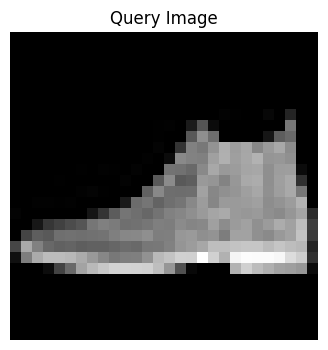


Top 10 Search Result Images:


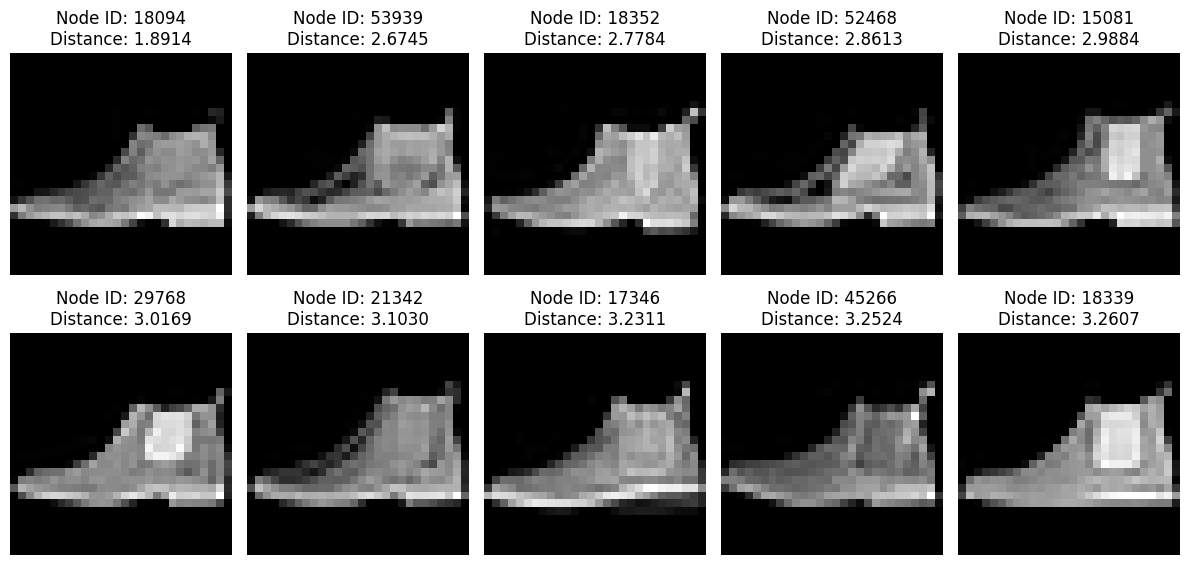

In [12]:
import matplotlib.pyplot as plt

# Reshape the query vector back to its original image shape (28x28 for Fashion MNIST)
query_image = query_vector.reshape(28, 28)

# Display the query image
plt.figure(figsize=(4, 4))
plt.imshow(query_image, cmap='gray')
plt.title("Query Image")
plt.axis('off')
plt.show()

# Display the top 10 search result images
print("\nTop 10 Search Result Images:")
plt.figure(figsize=(12, 6))
for i, (node_id, distance) in enumerate(results):
    # Get the vector from the base_vectors using the node_id
    result_vector = base_vectors[node_id]
    # Reshape the result vector back to its original image shape
    result_image = result_vector.reshape(28, 28)

    # Display the result image
    plt.subplot(2, 5, i + 1)
    plt.imshow(result_image, cmap='gray')
    plt.title(f"Node ID: {node_id}\nDistance: {distance:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.show()